In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [13]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

import optuna

rename dataset to optuna, remove scaling, have simple two part code, 1 for data prep and one for modelling, apply optuna to modelling

###Step 0. 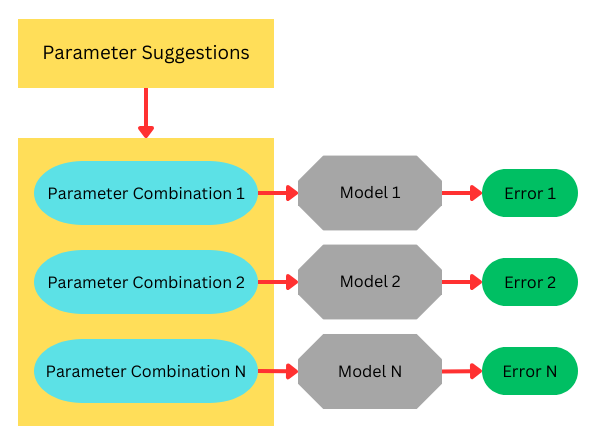Data Preparation

In [ ]:
df = pd.read_csv('optuna_dataset.csv')
df = pd.get_dummies(df, columns=df.select_dtypes(include = 'object').columns, drop_first=True)

X = df.drop('charges', axis = 1)
y = df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Step 1. Model Building

In [ ]:
rf_reg = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)
print(mean_absolute_error(y_pred, y_test))

2555.5928176791663


###Step 2. Optuna

In [75]:
def objective(trial):

    #1 Define hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 90, 110)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 6)

    #2 Create a Random Forest Regressor with the suggested hyperparameters
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    #3 Fit the model and caluclate error
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)

    return mae

###Step 3.

In [76]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2023-12-20 16:13:17,238] A new study created in memory with name: no-name-9716de58-1326-4b78-adeb-70e4f90be3a7
[I 2023-12-20 16:13:17,695] Trial 0 finished with value: 2380.309776367931 and parameters: {'n_estimators': 101, 'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 2380.309776367931.
[I 2023-12-20 16:13:18,309] Trial 1 finished with value: 2613.119252953442 and parameters: {'n_estimators': 106, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 2380.309776367931.
[I 2023-12-20 16:13:18,631] Trial 2 finished with value: 2370.3141504506116 and parameters: {'n_estimators': 108, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with value: 2370.3141504506116.
[I 2023-12-20 16:13:18,923] Trial 3 finished with value: 2593.440909361889 and parameters: {'n_estimators': 99, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 2 with value: 2370.

In [77]:
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 93, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 6}


In [78]:
# Train the final model with the best hyperparameters
best_rf = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    max_depth = best_params['max_depth'],
    random_state=42
)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=6,
                      n_estimators=93, random_state=42)

In [79]:
y_pred_best = best_rf.predict(X_test)

In [80]:
mean_absolute_error(y_pred_best, y_test)

2294.2876751820654